<a href="https://colab.research.google.com/github/heroza/Oversampling/blob/main/Skin_Cancer_Diagnosis_using_ADASYN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Attention

In [2]:
import tensorflow as tf
import tensorflow.keras as tk
from tensorflow.keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,Add,ZeroPadding2D,Flatten,Dense,Input,LeakyReLU,Softmax,ReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
import pickle
import numpy as np
from PIL import Image

class Attention(tk.layers.Layer):
    
    def __init__(self,input_channels,output_channel,kernel_size,groups):
        super().__init__()
        self.input_channels = input_channels
        self.output_channel = output_channel    
        self.kernel_size = kernel_size
        self.stride = 1
        self.groups = groups

        assert output_channel % groups == 0
        
        self.rel_h = tk.backend.variable(lambda : tk.backend.truncated_normal((1,1,kernel_size,1,output_channel//2),stddev = 0.1)) 
        #output_channels//2 is the number of channels on which the relative position will be considered,1 denotes the number of those filters and the one after that too and (kernel_size,1) denotes the size of that filter
        self.rel_w = tk.backend.variable(lambda : tk.backend.truncated_normal((1,1,1,kernel_size,output_channel//2),stddev = 0.1)) 

        self.key_weights = Conv2D(self.output_channel,kernel_size = 1,strides = self.stride)
        self.query_weights = Conv2D(self.output_channel,kernel_size = 1,strides = self.stride)
        self.value_weights = Conv2D(self.output_channel,kernel_size = 1,strides = self.stride)

    def call(self,x):
        
        batch,height,width,channels = x.shape
        x_padded = ZeroPadding2D(padding=(self.kernel_size//2,self.kernel_size//2))(x)
        query = self.query_weights(x)
        value = self.value_weights(x_padded)
        key = self.key_weights(x_padded)
        #key,query and value will have the shape of (batch,height,width,depth)
        keys = tf.image.extract_patches(images = key,sizes = [1,self.kernel_size,self.kernel_size,1],strides = [1,self.stride,self.stride,1],rates = [1,1,1,1], padding = "VALID")
        value = tf.image.extract_patches(images = value,sizes = [1,self.kernel_size,self.kernel_size,1],strides = [1,self.stride,self.stride,1],rates = [1,1,1,1], padding = "VALID")
        no_of_kernels = key.shape[-2] - self.kernel_size + 1
        keys = tf.reshape(keys,shape = (-1,no_of_kernels, no_of_kernels,self.kernel_size,self.kernel_size,self.output_channel))
        key_split_h,key_split_w = tf.split(keys,num_or_size_splits = 2,axis = -1)
        key_with_rel = tk.layers.concatenate([key_split_h + self.rel_h,key_split_w + self.rel_w],axis = -1) 
        
        #reshaping the query and key
        key_with_rel = tf.reshape(key_with_rel,(-1,self.groups,no_of_kernels,no_of_kernels,self.kernel_size*self.kernel_size,self.output_channel//self.groups))
        query  = tf.reshape(query,(-1,self.groups,no_of_kernels,no_of_kernels,1,self.output_channel//self.groups))        
        value = tf.reshape(value,(-1,self.groups,no_of_kernels,no_of_kernels,self.kernel_size*self.kernel_size,self.output_channel//self.groups))
        
        #multiplication  of key and query
        #assert key_with_rel.shape == query.shape        
        key_prod_query = query*key_with_rel
        
        # Now the function is passed through the softmax and is multiplied with the values
        s = Softmax(axis = -2)(key_prod_query)
        y = tf.einsum('bnchwk,bnchwk->bnchk',s,value)
        y = tf.reshape(y,(-1,height,width,self.output_channel))
        return y

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            "input_channels": self.input_channels, 
            "output_channel": self.output_channel, 
            "kernel_size": self.kernel_size, 
            "stride": self.stride, 
            "groups": self.groups, 
            "rel_h": self.rel_h, 
            "rel_w": self.rel_w, 
            "key_weights": self.key_weights, 
            "query_weights": self.query_weights, 
            "value_weights": self.value_weights
        })
        return config


#Library, atribut, and function

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
from pathlib import Path
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support, balanced_accuracy_score, confusion_matrix, accuracy_score
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input, Dropout, Flatten
from tensorflow.keras.models import Model, load_model
from keras.utils.np_utils import to_categorical

!pip install imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# input image size
IMAGE_W = 224
IMAGE_H = 224
IMG_SIZE = (IMAGE_W,IMAGE_H)
num_classes = 7
EPOCHS = 10
BATCH_SIZE = 64
opt_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
opt_SGD = SGD(learning_rate=0.001)
the_arch = 'resnet50'

#Data augmentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2), 
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3)),
  layers.experimental.preprocessing.RandomTranslation(0.3, 0.3, fill_mode='reflect', interpolation='bilinear',)
])

#Callbacks
best_model_fpath = '/content/drive/MyDrive/PHD/Model/best_model_attention.h5'
last_model_fpath = '/content/drive/MyDrive/PHD/Model/last_model_attention.h5'
mc = ModelCheckpoint(best_model_fpath, monitor='val_balanced_acc', mode='max', verbose=1, save_best_only=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_balanced_acc', patience=20, verbose=1, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=30,monitor='val_balanced_acc')


In [3]:
# load train and test dataset
def preprocess_image_input(input_images, arch = the_arch):
  input_images = input_images.astype('float32')
  if arch == 'inception_v3':
    output_ims = tf.keras.applications.inception_v3.preprocess_input(input_images)
  else:
    output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

def load_cifar10_dataset():
  from keras.datasets import cifar10
    # load dataset
  (X_train, y_train), (X_val, y_val) = cifar10.load_data()
    # one hot encode target values
  y_train = to_categorical(y_train)
  y_val = to_categorical(y_val)

  return X_train, y_train, X_val, y_val

def balanced_acc(y_true, y_pred):
    from keras import backend as K

    tensor1 = tf.math.argmax(y_true, axis=1)
    tensor2 = tf.math.argmax(y_pred, axis=1)

    cm = tf.math.confusion_matrix(tensor1, tensor2)
    
    diag = tf.linalg.tensor_diag_part (cm)
    tpfn = tf.cast(K.sum(cm, axis = 1), tf.float32) + K.epsilon()
    recall = tf.divide(tf.cast(diag, tf.float32),tpfn)
    balanced_acc = K.mean(recall)
    return balanced_acc

def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(10, activation='softmax'))
    # compile model
    opt = SGD(learning_rate=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def define_base_model(arch = the_arch, start_trainable_layer = 9999, attention=False):
  #x = UpSampling2D(size=(7,7))(input_tensor)
  #x = data_augmentation(input_tensor)
  #x = layers.Rescaling(1.0 / 255)(input_tensor)  # Rescale inputs
  if arch != 'dense':
    input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
    if arch == 'resnet50':
      base_model = ResNet50(input_tensor=input_tensor, weights='imagenet', include_top=False)
    elif arch == 'inception_v3':
      base_model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=False)
    elif arch == 'ResNet':
      base_model = ResNet(classes ,image_shape)(input_tensor)
    x = base_model.output
    if attention:
      x = Attention(1024,1024,7,8)(x)
    x = GlobalAveragePooling2D()(x)
    for layer in base_model.layers:
      layer.trainable = False
    if start_trainable_layer != 9999:
      for layer in base_model.layers[start_trainable_layer:]:
        layer.trainable = True
  else:
    input_tensor = Input(shape=(2048))
    x = input_tensor
  #x = Flatten()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.2)(x)
  x = Dense(512, activation='relu')(x)
  predictions = Dense(num_classes, activation='softmax')(x)
  model = Model(inputs=input_tensor, outputs=predictions)
  model.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
  return model

# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
 
# scale pixels
def norm_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

def load_isic2018_dataset(train_under_frac = 0):
  df_train = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv') 
  df_val = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv') 

  #decode one hot label
  df_train["Labels"] = (df_train.iloc[:, 1:]).idxmax(axis=1)
  df_val["Labels"] = (df_val.iloc[:, 1:]).idxmax(axis=1)

  #random undersampling for training dataset
  if train_under_frac !=0:
    df_train = df_train.drop(df_train[df_train['Labels'] == 'NV'].sample(frac=train_under_frac).index)

  #drop one-hot column
  df_train = df_train.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])
  df_val = df_val.drop(columns=['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC'])

  #make filepaths of the image
  dir_train = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_Input/'
  dir_val = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Validation_Input/'
  df_train['FilePaths'] = dir_train + df_train['image'] + '.jpg'
  df_val['FilePaths'] = dir_val + df_val['image'] + '.jpg'
  
  #load image pixels to dataframe
  df_train['image_px'] = df_train['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))
  df_val['image_px'] = df_val['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  y_train = np.array(df_train['Labels'].values)
  y_val = np.array(df_val['Labels'].values)

  label_encoder = preprocessing.LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_val = label_encoder.fit_transform(y_val)
  
  y_train = to_categorical(y_train, num_classes = num_classes)
  y_val = to_categorical(y_val, num_classes = num_classes)

  return X_train, y_train, X_val, y_val, df_train, df_val

def reset_dataset(df_train, df_val):
  X_train = np.asarray(df_train['image_px'].tolist())
  X_val = np.asarray(df_val['image_px'].tolist())
  y_train = np.array(df_train['Labels'].values)
  y_val = np.array(df_val['Labels'].values)

  X_train = preprocess_image_input(X_train, the_arch)
  X_val = preprocess_image_input(X_val, the_arch)

  label_encoder = preprocessing.LabelEncoder()
  y_train = label_encoder.fit_transform(y_train)
  y_val = label_encoder.fit_transform(y_val)
  
  y_train = to_categorical(y_train, num_classes = num_classes)
  y_val = to_categorical(y_val, num_classes = num_classes)
  return X_train, y_train, X_val, y_val

def SMOTE_Data(X, y, one_hot = False, k = 5, width = IMAGE_W, height = IMAGE_H, c = 3, type = 'smote'):
  if one_hot:
    y = np.argmax(y, axis=1)
  if type == 'borderline':
    sm = BorderlineSMOTE()
  elif type == 'svm':
    sm = SVMSMOTE()
  elif type == 'adasyn':
    sm = ADASYN(random_state=42, n_neighbors=k)
  elif type == 'kmeans':
    sm = KMeansSMOTE()
  else:
    sm = SMOTE(random_state=42, k_neighbors=k)
  X_resampled, y_resampled = sm.fit_resample(X.reshape((-1, width * height * c)), y)
  X_resampled = X_resampled.reshape(-1, width, height, c)
  if one_hot:
    y_resampled = to_categorical(y_resampled, num_classes = num_classes)
  else:
    y_resampled = y_resampled.reshape(-1,1)
  return X_resampled, y_resampled

def SMOTE_Data2(X, y, one_hot = False, k = 5):
  if one_hot:
    y = np.argmax(y, axis=1)
  sm = SMOTE(random_state=42, k_neighbors=k)
  X_resampled, y_resampled = sm.fit_resample(X, y)
  if one_hot:
    y_resampled = to_categorical(y_resampled, num_classes = num_classes)
  else:
    y_resampled = y_resampled.reshape(-1,1)
  return X_resampled, y_resampled

#Exp

In [ ]:
input_tensor = Input(shape=(IMAGE_H, IMAGE_W, 3))
base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
x = base_model(input_tensor, training=False)
x = Attention(2048,2048,7,8)(x)
x = GlobalAveragePooling2D()(x)
res50 = Model(inputs=input_tensor, outputs=x)

In [ ]:
#Train i-last layer
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # summarize output shape
    print(i, layer.name, layer.output.shape)

0 input_1 (None, 224, 224, 3)
1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 conv1_bn (None, 112, 112, 64)
4 conv1_relu (None, 112, 112, 64)
5 pool1_pad (None, 114, 114, 64)
6 pool1_pool (None, 56, 56, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_conv (None, 56, 56, 64)
11 conv2_block1_2_bn (None, 56, 56, 64)
12 conv2_block1_2_relu (None, 56, 56, 64)
13 conv2_block1_0_conv (None, 56, 56, 256)
14 conv2_block1_3_conv (None, 56, 56, 256)
15 conv2_block1_0_bn (None, 56, 56, 256)
16 conv2_block1_3_bn (None, 56, 56, 256)
17 conv2_block1_add (None, 56, 56, 256)
18 conv2_block1_out (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)
20 conv2_block2_1_bn (None, 56, 56, 64)
21 conv2_block2_1_relu (None, 56, 56, 64)
22 conv2_block2_2_conv (None, 56, 56, 64)
23 conv2_block2_2_bn (None, 56, 56, 64)
24 conv2_block2_2_relu (None, 56, 56, 64)
25 conv2_block2_3_conv (None, 56

In [ ]:
X_train = res50.predict(X_train)
X_val = res50.predict(X_val)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(5321, 2048)
(5321, 7)
(193, 2048)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
X_train, y_train = SMOTE_Data2(X_train, y_train, True)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(14077, 2048)
(14077, 7)
(193, 2048)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 2011, 2: 2011, 3: 2011, 0: 2011, 1: 2011, 6: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


# Main

In [4]:
path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
df1 = pd.read_pickle(path+"isic2018_train.pkl")
X_train = df1.loc[:, df1.columns != 'y_train'].to_numpy()
X_train = X_train.reshape(-1,224,224,3)
y_train = df1.loc[:, df1.columns == 'y_train'].to_numpy()
y_train = to_categorical(y_train)

df1 = pd.read_pickle(path+"isic2018_val.pkl")
X_val = df1.loc[:, df1.columns != 'y_val'].to_numpy()
X_val = X_val.reshape(-1,224,224,3)
y_val = df1.loc[:, df1.columns == 'y_val'].to_numpy()
y_val = to_categorical(y_val)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(5321, 224, 224, 3)
(5321, 7)
(193, 224, 224, 3)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [5]:
X_train, y_train = SMOTE_Data(X_train, y_train, True, type='adasyn')
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(14195, 224, 224, 3)
(14195, 7)
(193, 224, 224, 3)
(193, 7)
Counter train data:  Counter({1: 2093, 4: 2052, 6: 2042, 3: 2033, 0: 2020, 5: 2011, 2: 1944})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
#path = '/content/drive/MyDrive/PHD/Datasets/isic2018/'
#df1 = pd.DataFrame(X_train.reshape(X_train.shape[0],-1))
#df1['y_train'] = np.argmax(y_train, axis=1).tolist()
#df2 = pd.DataFrame(X_val.reshape(X_val.shape[0],-1))
#df2['y_val'] = np.argmax(y_val, axis=1).tolist()
#df1.to_pickle(path+"isic2018_train.pkl")
#df2.to_pickle(path+"isic2018_val.pkl")

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(5321, 224, 224, 3)
(5321, 7)
(193, 224, 224, 3)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 1113, 2: 1099, 1: 514, 0: 327, 6: 142, 3: 115})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


Epoch 1/10
221/221 [==============================] - ETA: 0s - loss: 1.6696 - accuracy: 0.3574 - balanced_acc: 0.3557
Epoch 1: val_balanced_acc improved from -inf to 0.36466, saving model to /content/drive/MyDrive/PHD/Model/best_model_attention.h5
221/221 [==============================] - 61s 218ms/step - loss: 1.6696 - accuracy: 0.3574 - balanced_acc: 0.3557 - val_loss: 1.4027 - val_accuracy: 0.5026 - val_balanced_acc: 0.3647 - lr: 0.0010
Epoch 2/10
221/221 [==============================] - ETA: 0s - loss: 1.2818 - accuracy: 0.5327 - balanced_acc: 0.5312
Epoch 2: val_balanced_acc improved from 0.36466 to 0.39124, saving model to /content/drive/MyDrive/PHD/Model/best_model_attention.h5
221/221 [==============================] - 47s 207ms/step - loss: 1.2818 - accuracy: 0.5327 - balanced_acc: 0.5312 - val_loss: 1.2391 - val_accuracy: 0.5544 - val_balanced_acc: 0.3912 - lr: 0.0010
Epoch 3/10
221/221 [==============================] - ETA: 0s - loss: 1.1397 - accuracy: 0.5847 - balance

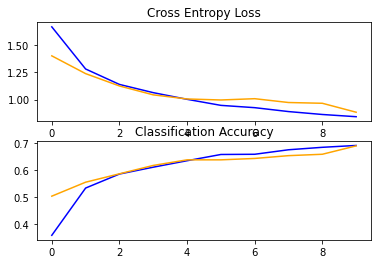

In [7]:
# define model
model = define_base_model('resnet50')
#model.summary()
hst = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val, y_val), verbose=1,
                    steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])
# learning curves
summarize_diagnostics(hst)

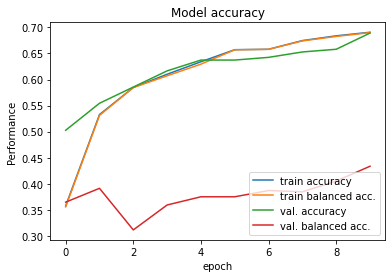

In [8]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['balanced_acc'])
plt.plot(hst.history['val_accuracy'])
plt.plot(hst.history['val_balanced_acc'])
plt.title('Model accuracy')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'train balanced acc.', 'val. accuracy', 'val. balanced acc.'], loc='lower right')
plt.show()

In [ ]:
#Training
#hst = model.fit(train_data_batches,
#                    epochs = EPOCHS, validation_data = valid_data_batches,      
                    #steps_per_epoch=X_train.shape[0] // BATCH_SIZE, 
#                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


#Evaluate

In [9]:
#save last model
model.save(last_model_fpath)

In [6]:
last_model = load_model(last_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = last_model.predict(X_train)
y_val_pred = last_model.predict(X_val)

#print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

accuracy on training 0.7315251849242691
balanced accuracy on training 0.7302495318595627
accuracy on validation 0.689119170984456
balanced accuracy on validation 0.6577318732370997
Score on val data:  (0.46998544748969195, 0.6577318732370997, 0.5075435172287472, None)


In [6]:
best_model = load_model(best_model_fpath, custom_objects={'balanced_acc' : balanced_acc})
y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print('accuracy on training',accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

accuracy on training 0.7315251849242691
balanced accuracy on training 0.7302495318595627
accuracy on validation 0.689119170984456
balanced accuracy on validation 0.6577318732370997
Score on val data:  (0.46998544748969195, 0.6577318732370997, 0.5075435172287472, None)


#Cut-off

In [ ]:
df_val_pred = pd.DataFrame(y_val_pred, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

In [ ]:
numbers = [float(x)/40 for x in range(11)]
for i in numbers:
    df_val_pred[i]= df_val_pred.MEL.map(lambda x: 1 if x > i else 0)
df_val_pred.head()

,AKIEC,BCC,BKL,DF,MEL,NV,VASC,0.0,0.025,0.05,0.075,0.1,0.125,0.15,0.175,0.2,0.225,0.25
0,0.000005,8.485875e-01,0.010974,1.638218e-02,0.067681,0.053216,3.155297e-03,1,1,1,0,0,0,0,0,0,0,0
1,0.000001,1.249555e-06,0.003009,4.066068e-05,0.003696,0.993216,3.473017e-05,1,0,0,0,0,0,0,0,0,0,0
2,0.001005,9.988480e-01,0.000061,3.781584e-06,0.000065,0.000017,4.135021e-07,1,0,0,0,0,0,0,0,0,0,0
3,0.000001,6.159509e-06,0.013044,3.545333e-05,0.012993,0.968286,5.633445e-03,1,0,0,0,0,0,0,0,0,0,0
4,0.000058,2.258765e-07,0.000133,5.973683e-07,0.003996,0.995811,1.017195e-06,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
y_val_true= [1 if x == 4 else 0 for x in np.argmax(y_val, axis=1)]

In [ ]:
#num = [0.0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
cutoff_df = pd.DataFrame( columns = ['Probability','Accuracy','Sensitivity','Specificity'])
for i in numbers:
    cm1 = confusion_matrix(y_val_true, df_val_pred[i])
    total1=sum(sum(cm1))
    Accuracy = (cm1[0,0]+cm1[1,1])/total1
    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,Accuracy,Sensitivity,Specificity]

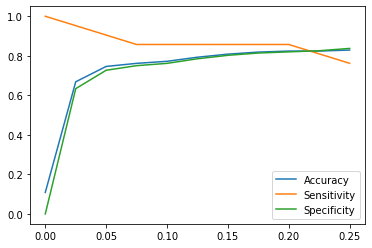

In [ ]:
cutoff_df[['Accuracy','Sensitivity','Specificity']].plot()

plt.show()

In [ ]:
i = 0.025
cm1 = confusion_matrix(y_val_true, df_val_pred[i])
total1=sum(sum(cm1))
Accuracy = (cm1[0,0]+cm1[1,1])/total1
Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

In [ ]:
print('Accuracy: ', Accuracy)
print('Sensitivity: ', Sensitivity)
print('Specificity: ', Specificity)

Accuracy:  0.6683937823834197
Sensitivity:  0.9523809523809523
Specificity:  0.6337209302325582


#Confusion Metric on Validation Set

In [ ]:
#change melanoma flag back to 4
df_val_pred[df_val_pred[i] == 1] = 4
#decode one-hot y_val_pred while use cut-off melanoma data
condition = df_val_pred[i] == 4
y_val_pred2 = np.where(condition, df_val_pred[i], np.argmax(y_val_pred, axis=1))

In [ ]:
print('Accuracy: ',accuracy_score(np.argmax(y_val, axis=1), y_val_pred2))
print('Balanced accuracy: ',balanced_accuracy_score(np.argmax(y_val, axis=1), y_val_pred2))

Accuracy:  0.6010362694300518
Balanced accuracy:  0.5054425539617177


In [ ]:
#Get the confusion matrix
cf_matrix = confusion_matrix(np.argmax(y_val, axis=1), y_val_pred2)
print(cf_matrix)

[[ 3  0  2  0  3  0  0]
 [ 3  8  0  1  3  0  0]
 [ 0  0  9  1 12  0  0]
 [ 0  0  1  0  0  0  0]
 [ 0  0  1  0 20  0  0]
 [ 0  1  4  0 44 74  0]
 [ 0  0  0  0  1  0  2]]


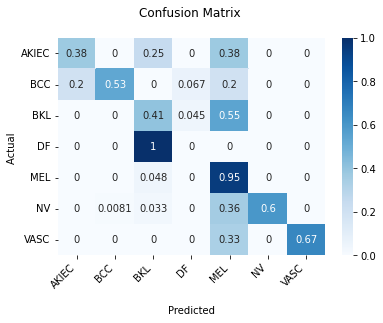

In [ ]:
ax = sns.heatmap(cf_matrix / cf_matrix.sum(axis=1, keepdims=True), annot=True, 
            cmap='Blues')

ax.set_title('Confusion Matrix \n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
ax.yaxis.set_ticklabels(['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])

plt.rcParams["figure.figsize"] = (15,3)

## Display the visualization of the Confusion Matrix.
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0, ha='right')
plt.show()

In [ ]:
# ordered count of rows per unique label
#labels_count = df_val['Labels'].value_counts().sort_index()

#f = plt.figure(figsize=(15, 6))
#s = sns.barplot(x=labels_count.index,y=labels_count.values)
#s.set_xticklabels(s.get_xticklabels(), rotation = 30)

#Testing

In [ ]:
dir_test = '/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Test_Input/'
filepaths = sorted( filter( lambda x: (os.path.isfile(os.path.join(dir_test, x))) and (x.endswith('.jpg')),
                        os.listdir(dir_test) ) )

In [ ]:
df_test = pd.DataFrame(filepaths, columns =['image'])
df_test['FilePaths'] = dir_test + df_test['image']
#df_test

In [ ]:
df_test['image_px'] = df_test['FilePaths'].map(lambda x: np.asarray(Image.open(x).resize(IMG_SIZE)))

In [ ]:
X_test = np.asarray(df_test['image_px'].tolist())
print(np.array(X_test).shape)

(1512, 224, 224, 3)


In [ ]:
#preprocess
X_test = preprocess_image_input(X_test)

Calculate y_pred from training and testing for analysis

In [ ]:
#X_test = model.predict(X_test)

In [ ]:
# predicting
#CHANGE THE MODEL IF NECESSARY
#X_test2 = model1.predict(X_test)
Y_pred2 = model.predict(X_test2)
print("Y_pred2", Y_pred2.shape)

NameError: ignored

In [ ]:
df_pred = pd.DataFrame(Y_pred2, columns = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC'])
df_pred['image'] = df_test['FilePaths'].map(lambda x: x.replace(dir_test, '').replace('.jpg', ''))
df_pred = df_pred[['image', 'MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']]
df_pred.set_index("image", inplace = True)

In [ ]:
#update MEL data using cut-off value
df_pred.MEL[df_pred.MEL > i] = 1

In [ ]:
df_pred.loc[df_pred.MEL > i, ['NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']] = 0

In [ ]:
df_pred.to_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/response_SMOTE_Attention.csv')

result: 0.656

#Oversampling on feature map level

In [ ]:
i = 176

In [ ]:
for i in range(len(model.layers)):
  layer = model.layers[i]
  print(i, layer.name, layer.output_shape, layer.trainable)

In [ ]:
# redefine model to output right after the first hidden layer
model1 = Model(inputs=model.inputs, outputs=model.layers[i].output)

In [ ]:
# get feature map for first hidden layer
X_train_fm = model1.predict(X_train)
X_val_fm = model1.predict(X_val)

In [ ]:
X_train_fm.shape

(5321, 1024)

In [ ]:
X_train_fm_ov, y_train_ov = SMOTE_Data2(X_train_fm, y_train, True, 5)
print(X_train_fm_ov.shape)
print(y_train_ov.shape)
print(X_val.shape)
print(y_val.shape)
print('Counter train data: ', Counter(np.argmax(y_train_ov, axis=1)))
print('Counter val data: ', Counter(np.argmax(y_val, axis=1)))

(14077, 1024)
(14077, 7)
(193, 224, 224, 3)
(193, 7)
Counter train data:  Counter({5: 2011, 4: 2011, 2: 2011, 3: 2011, 0: 2011, 1: 2011, 6: 2011})
Counter val data:  Counter({5: 123, 2: 22, 4: 21, 1: 15, 0: 8, 6: 3, 3: 1})


In [ ]:
model2 = Model(inputs=model.layers[i].output, outputs=model.layers[len(model.layers)-1].output)

In [ ]:
best_model_fpath = '/content/drive/MyDrive/PHD/Model/Feature-Map-Ov/best_model_no.h5'
last_model_fpath = '/content/drive/MyDrive/PHD/Model/Feature-Map-Ov/last_model_no.h5'
model2.compile(optimizer = opt_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
hst = model2.fit(X_train_fm_ov, y_train_ov, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_fm, y_val), verbose=1,
                    steps_per_epoch=X_train_fm_ov.shape[0] // BATCH_SIZE, 
                    callbacks=[learning_rate_reduction,early_stopping_monitor])

Epoch 1/300
219/219 [==============================] - 2s 5ms/step - loss: 0.4858 - accuracy: 0.8572 - balanced_acc: 0.8576 - val_loss: 0.7743 - val_accuracy: 0.7202 - val_balanced_acc: 0.4059 - lr: 5.0000e-04
Epoch 2/300
219/219 [==============================] - 1s 4ms/step - loss: 0.4547 - accuracy: 0.8693 - balanced_acc: 0.8688 - val_loss: 0.7978 - val_accuracy: 0.6995 - val_balanced_acc: 0.3985 - lr: 5.0000e-04
Epoch 3/300
219/219 [==============================] - 1s 4ms/step - loss: 0.4385 - accuracy: 0.8755 - balanced_acc: 0.8728 - val_loss: 0.7950 - val_accuracy: 0.6995 - val_balanced_acc: 0.3985 - lr: 5.0000e-04
Epoch 4/300
219/219 [==============================] - 1s 4ms/step - loss: 0.4306 - accuracy: 0.8717 - balanced_acc: 0.8706 - val_loss: 0.7831 - val_accuracy: 0.6995 - val_balanced_acc: 0.3984 - lr: 5.0000e-04
Epoch 5/300
219/219 [==============================] - 1s 4ms/step - loss: 0.4201 - accuracy: 0.8767 - balanced_acc: 0.8771 - val_loss: 0.7902 - val_accuracy: 0

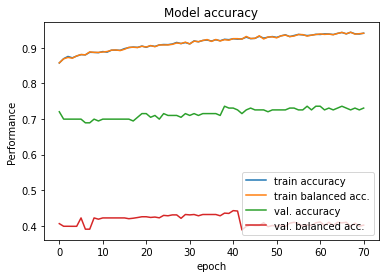

In [ ]:
# summarize history for accuracy
plt.plot(hst.history['accuracy'])
plt.plot(hst.history['balanced_acc'])
plt.plot(hst.history['val_accuracy'])
plt.plot(hst.history['val_balanced_acc'])
plt.title('Model accuracy')
plt.ylabel('Performance')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'train balanced acc.', 'val. accuracy', 'val. balanced acc.'], loc='lower right')
plt.show()

In [ ]:
# get feature map for first hidden layer
y_train_pred = model2.predict(X_train_fm_ov)
y_val_pred = model2.predict(X_val_fm)

In [ ]:
print('accuracy on training',accuracy_score(np.argmax(y_train_ov, axis=1), np.argmax(y_train_pred, axis=1)))
print('balanced accuracy on training',balanced_accuracy_score(np.argmax(y_train_ov, axis=1), np.argmax(y_train_pred, axis=1)))
print('accuracy on validation',accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('balanced accuracy on validation',balanced_accuracy_score(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1)))
print('Score on val data: ',precision_recall_fscore_support(np.argmax(y_val, axis=1), np.argmax(y_val_pred, axis=1), average='macro'))

accuracy on training 0.959508417986787
balanced accuracy on training 0.959508417986787
accuracy on validation 0.7305699481865285
balanced accuracy on validation 0.5420233947237432
Score on val data:  (0.47325132163460576, 0.5420233947237432, 0.4999546186338479, None)


#Load ISIC 2018 Challange Data

In [ ]:
X_train, y_train, X_val, y_val = load_isic2018_dataset(train_under_frac = 0.7)

[Text(0, 0, 'DF'),
 Text(0, 0, 'VASC'),
 Text(0, 0, 'AKIEC'),
 Text(0, 0, 'BCC'),
 Text(0, 0, 'BKL'),
 Text(0, 0, 'MEL'),
 Text(0, 0, 'NV')]

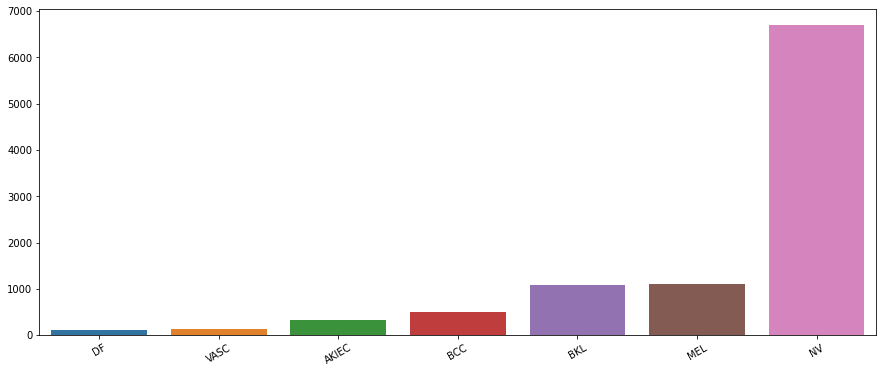

In [ ]:
# ordered count of rows per unique label
labels_count = y_train.value_counts(ascending=True)

f = plt.figure(figsize=(15, 6))
s = sns.barplot(x=labels_count.index,y=labels_count.values)
s.set_xticklabels(s.get_xticklabels(), rotation = 30)

Plot 3 images per label

ValueError: ignored

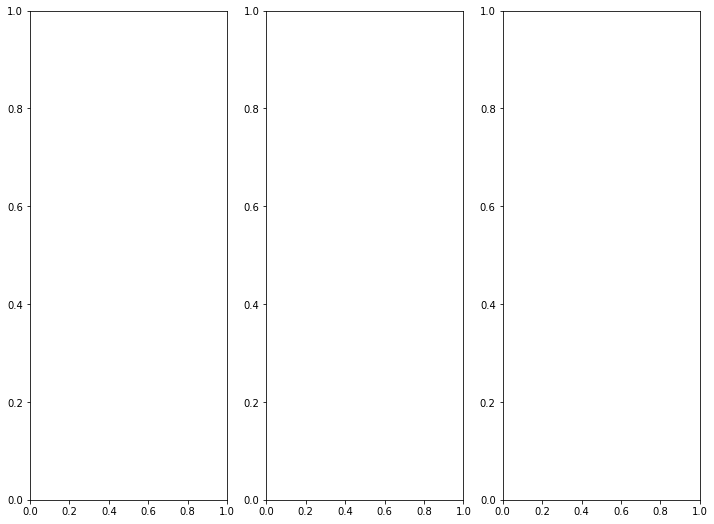

In [ ]:
def plot_images_per_label(df, label, cols: int, size: tuple):
    fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=size)

    cntMax = cols
    cntCur = 0
    for index, row in df.iterrows():
        if(y_train == label and cntCur < cntMax):
            axs[cntCur].imshow(plt.imread(df.FilePaths[index]))
            axs[cntCur].set_title(df.Labels[index])

            cntCur += 1
        else:
            if(cntCur >= cntMax):
                break
    
    plt.tight_layout()
    plt.show()


# unique labels
labels = sorted(df1['y_train'].unique())
for label in range(7):
    plot_images_per_label(df1, label, 3, (12,9))

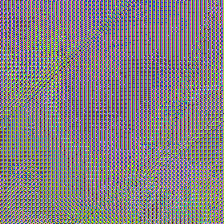

In [ ]:
from PIL import Image
img = Image.fromarray(X_train[0], 'RGB')
display(img)

Drop duplicate images

In [ ]:
#df_group = pd.read_csv('/content/drive/MyDrive/PHD/Datasets/isic2018/ISIC2018_Task3_Training_LesionGroupings.csv') 
#df_train = df_train.set_index('image').join(df_group.set_index('image'))
#df_train = df_train.drop_duplicates(subset=['lesion_id'])

#DeepSMOTE Oversampling

In [ ]:
from numpy import moveaxis
from sklearn.neighbors import NearestNeighbors
import torch
import torch.nn as nn

max_el = np.inf

args = {}
args['dim_h'] = 64         # factor controlling size of hidden layers
args['n_channel'] = 3#1    # number of channels in the input data 
args['n_z'] = 600 #300     # number of dimensions in latent space. 
args['sigma'] = 1.0        # variance in n_z
args['lambda'] = 0.01      # hyper param for weight of discriminator loss
args['lr'] = 0.0002        # learning rate for Adam optimizer .000
args['epochs'] = 300       # how many epochs to run for
args['batch_size'] = 100   # batch size for SGD
args['save'] = True        # save weights at each epoch of training if True
args['train'] = True       # train networks if True, else load networks from
args['patience'] = 20

In [ ]:
class Encoder(nn.Module):
    def __init__(self, args):
        super(Encoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']
        
        # convolutional filters, work excellent with image data
        # [(W−K+2P)/S]+1
        self.conv = nn.Sequential(
            nn.AvgPool2d(7, stride=7),
            nn.Conv2d(self.n_channel, self.dim_h, 4, 2, 1, bias=False),# 16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h, self.dim_h * 2, 4, 2, 1, bias=False), # 8
            nn.BatchNorm2d(self.dim_h * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 2, self.dim_h * 4, 4, 2, 1, bias=False),# 4
            nn.BatchNorm2d(self.dim_h * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(self.dim_h * 4, self.dim_h * 8, 4, 2, 0, bias=False),#14
            nn.BatchNorm2d(self.dim_h * 8),
            nn.LeakyReLU(0.2, inplace=True))
        self.fc = nn.Linear(self.dim_h * (2 ** 3), self.n_z)

    def forward(self, x):
        x = self.conv(x)
        
        x = x.squeeze()
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, args):
        super(Decoder, self).__init__()

        self.n_channel = args['n_channel']
        self.dim_h = args['dim_h']
        self.n_z = args['n_z']

        # first layer is fully connected
        self.fc = nn.Sequential(
            nn.Linear(self.n_z, self.dim_h * 2**3 * 7 * 7),
            nn.ReLU())

        # deconvolutional filters, essentially inverse of convolutional filters
        # H_out ​= (H_in​−1)*stride[0] − 2×padding[0] + dilation[0]×(kernel_size[0]−1) + output_padding[0] + 1
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(self.dim_h * 8, self.dim_h * 4, 4), #10
            nn.BatchNorm2d(self.dim_h * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 4, self.dim_h * 2, 4), #13
            nn.BatchNorm2d(self.dim_h * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h * 2, self.dim_h, 4),# 16
            nn.BatchNorm2d(self.dim_h),
            nn.ReLU(True),
            nn.ConvTranspose2d(self.dim_h, 3, 4, 2, 1),# 32
            nn.UpsamplingBilinear2d(scale_factor=7),
            nn.Tanh())

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim_h * 2**3, 7, 7)
        x = self.deconv(x)
        return x

##############################################################################
"""set models, loss functions"""
# control which parameters are frozen / free for optimization
def free_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = True

def frozen_params(module: nn.Module):
    for p in module.parameters():
        p.requires_grad = False

def biased_get_class(X, y, c):
    
    xbeg = X[y == c]
    ybeg = y[y == c]
    
    return xbeg, ybeg
    #return xclass, yclass

def G_SM(X, y,n_to_sample,cl):
    n_neigh = 5
    nn = NearestNeighbors(n_neighbors=n_neigh, n_jobs=1)
    nn.fit(X)
    dist, ind = nn.kneighbors(X)

    # generating samples
    base_indices = np.random.choice(list(range(len(X))),n_to_sample)
    neighbor_indices = np.random.choice(list(range(1, n_neigh)),n_to_sample)

    X_base = X[base_indices]
    X_neighbor = X[ind[base_indices, neighbor_indices]]

    samples = X_base + np.multiply(np.random.rand(n_to_sample,1),
            X_neighbor - X_base)

    #use 10 as label because 0 to 9 real classes and 1 fake/smoted = 10
    return samples, [cl]*n_to_sample

def DeepSMOTE_train(X_train, y_train, one_hot = False):
  from torch.utils.data import TensorDataset
  import os

  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #X_train = X_train.astype('float32') / 255.
  
  batch_size = args['batch_size']
  patience = args['patience']
  encoder = Encoder(args)
  decoder = Decoder(args)

  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  print(device)
  decoder = decoder.to(device)
  encoder = encoder.to(device)

  train_on_gpu = torch.cuda.is_available()

  #decoder loss function
  criterion = nn.MSELoss()
  criterion = criterion.to(device)

  num_workers = 0

  #torch.Tensor returns float so if want long then use torch.tensor
  tensor_x = torch.from_numpy(X_train.copy())#torch.Tensor(X_train)
  tensor_y = torch.tensor(y_train,dtype=torch.long)
  mnist_bal = TensorDataset(tensor_x,tensor_y) 
  train_loader = torch.utils.data.DataLoader(mnist_bal, 
      batch_size=batch_size,shuffle=True,num_workers=num_workers)

  best_loss = np.inf

  enc_optim = torch.optim.Adam(encoder.parameters(), lr = args['lr'])
  dec_optim = torch.optim.Adam(decoder.parameters(), lr = args['lr'])

  for epoch in range(args['epochs']):
      train_loss = 0.0
      tmse_loss = 0.0
      tdiscr_loss = 0.0
      # train for one epoch -- set nets to train mode
      encoder.train()
      decoder.train()
  
      for images,labs in train_loader:
      
          # zero gradients for each batch
          encoder.zero_grad()
          decoder.zero_grad()
          images, labs = images.to(device), labs.to(device)
          labsn = labs.detach().cpu().numpy()
#            print('images shape', images.shape)
          # run images
          z_hat = encoder(images)
#            print('images shape after encoding', z_hat.shape)
      
          x_hat = decoder(z_hat) #decoder outputs tanh
#            print('images shape after decoding', x_hat.shape)
          mse = criterion(x_hat,images)
                  
          resx = []
          resy = []
      
          tc = np.random.choice(num_classes,1)
          #tc = 9
          xbeg = X_train[y_train == tc]
          ybeg = y_train[y_train == tc] 
          xlen = len(xbeg)
          nsamp = min(xlen, 100)
          ind = np.random.choice(list(range(len(xbeg))),nsamp,replace=False)
          xclass = xbeg[ind]
          yclass = ybeg[ind]
      
          xclen = len(xclass)
          xcminus = np.arange(1,xclen)
          
          xcplus = np.append(xcminus,0)
          xcnew = (xclass[[xcplus],:])
          xcnew = xcnew.reshape(xcnew.shape[1],xcnew.shape[2],xcnew.shape[3],xcnew.shape[4])
      
          xcnew = torch.Tensor(xcnew)
          xcnew = xcnew.to(device)
      
          #encode xclass to feature space
          xclass = torch.Tensor(xclass)
          xclass = xclass.to(device)
          xclass = encoder(xclass)
      
          xclass = xclass.detach().cpu().numpy()
      
          xc_enc = (xclass[[xcplus],:])
          xc_enc = np.squeeze(xc_enc)
      
          xc_enc = torch.Tensor(xc_enc)
          xc_enc = xc_enc.to(device)
          
          ximg = decoder(xc_enc)
          
          mse2 = criterion(ximg,xcnew)
      
          comb_loss = mse2 + mse
          comb_loss.backward()
      
          enc_optim.step()
          dec_optim.step()
      
          train_loss += comb_loss.item()*images.size(0)
          tmse_loss += mse.item()*images.size(0)
          tdiscr_loss += mse2.item()*images.size(0)

      train_loss = train_loss/len(train_loader)
      tmse_loss = tmse_loss/len(train_loader)
      tdiscr_loss = tdiscr_loss/len(train_loader)
      print('Epoch: {} \tTrain Loss: {:.6f} \tmse loss: {:.6f} \tmse2 loss: {:.6f}'.format(epoch,
              train_loss,tmse_loss,tdiscr_loss))
      
  
  
      #store the best encoder and decoder models
      #here, /crs5 is a reference to 5 way cross validation, but is not
      #necessary for illustration purposes
      if train_loss < best_loss:
          print('Saving..')
          patience = args['patience']
          path_enc = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/bst_enc.pth'
          path_dec = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/bst_dec.pth'
        
          torch.save(encoder.state_dict(), path_enc)
          torch.save(decoder.state_dict(), path_dec)
  
          best_loss = train_loss
      else:
          patience = patience - 1

      if patience == 0:
          print('Out of patience. \n')
          break

def DeepSMOTE_Data(X_train, y_train, one_hot = False):
  batch_size = args['batch_size']
  max_el = np.max(X_train)
  X_train = X_train / max_el
  X_train = moveaxis(X_train, 3, 1)
  if one_hot:
    y_train = np.argmax(y_train, axis=1)
  #Generate artificial images
  import torch
  np.printoptions(precision=5,suppress=True)

  #path on the computer where the models are stored
  modpth = '/content/drive/MyDrive/PHD/Model/DeepSMOTE/32/'

  path_enc = modpth + '/bst_enc.pth'
  path_dec = modpth + '/bst_dec.pth'
  
  train_on_gpu = torch.cuda.is_available()
  device = 'cuda' if torch.cuda.is_available() else 'cpu'

  encoder = Encoder(args)
  encoder.load_state_dict(torch.load(path_enc), strict=False)
  encoder = encoder.to(device)

  decoder = Decoder(args)
  decoder.load_state_dict(torch.load(path_dec), strict=False)
  decoder = decoder.to(device)

  encoder.eval()
  decoder.eval()

  resx = []
  resy = []
  
  counter = Counter(y_train)
  counter = sorted(counter.items())
  counter = [value for _, value in counter]

  for i in range(num_classes):
      torch.cuda.empty_cache()

      xclass, yclass = biased_get_class(X_train, y_train, i)
      #encode xclass to feature space
      xclass = torch.Tensor(xclass)
      xclass = xclass.to(device)
      xclass = encoder(xclass)
          
      xclass = xclass.detach().cpu().numpy()
      n = np.max(counter) - counter[i]
      if n == 0:
        continue
#        resx2 = []
#        resy2 = []
#        for j in range(batch_size, n+batch_size+1, batch_size):
#          if j <= n:
#            batch_size_max = batch_size
#          elif n % batch_size != 0:
#            batch_size_max = n%batch_size
#          else:
#            break
#          xsamp, ysamp = G_SM(xclass,yclass,batch_size_max,i)
      xsamp, ysamp = G_SM(xclass,yclass,n,i)
      ysamp = np.array(ysamp)
  
      """to generate samples for resnet"""   
      xsamp = torch.Tensor(xsamp)
      xsamp = xsamp.to(device)
      ximg = decoder(xsamp)

      ximn = ximg.detach().cpu().numpy()
#        resx2.append(ximn)
#        resy2.append(ysamp)
#        
#        resx2 = np.vstack(resx2)
#        resy2 = np.hstack(resy2)
      resx.append(ximn)
      resy.append(ysamp)
  
  resx1 = np.vstack(resx)
  resy1 = np.hstack(resy)
  resx1 = resx1.reshape(resx1.shape[0],-1)
  X_train = X_train.reshape(X_train.shape[0],-1)
  X_train = np.vstack((resx1,X_train))
  y_train = np.hstack((resy1,y_train))
  y_train = to_categorical(y_train)
  X_train = X_train.reshape(-1, 3, IMAGE_W, IMAGE_H)
  X_train = moveaxis(X_train, 1, 3)
  X_train = X_train * max_el
  return X_train, y_train

#Split dataset to train and val

In [ ]:
# stratified train and rem (20%) datasets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=1)

print('Train Data: ', X_train.shape)
print('Remaining Data: ', X_val.shape)

Train Data:  (11261, 224, 224, 3)
Remaining Data:  (2816, 224, 224, 3)


In [ ]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(X_train)

#Fine Tune

In [ ]:
limit = 171
for layer in model.layers[:limit]:
   layer.trainable = False
for layer in model.layers[limit:]:
   layer.trainable = True

optimizer_SGD = SGD(learning_rate=0.0001, momentum=0.9)
model.compile(optimizer = optimizer_SGD , loss = "categorical_crossentropy", metrics=['accuracy', balanced_acc])
hst2 = model.fit(train_data_batches,
                    epochs = EPOCHS, validation_data = valid_data_batches,
                    callbacks=[learning_rate_reduction,early_stopping_monitor, mc])


In [ ]:
# summarize history for accuracy
plt.plot(hst2.history['balanced_acc'])
plt.plot(hst2.history['val_balanced_acc'])
plt.title('model balance_acc after tunning')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()